Short Backwarding for Selecting the Best Historical Agent in a Consulting System for Portfolio Allocation with Deep Reinforcement Learning

## 6 Backtesting and Evaluation of the Portfolios

### 6.1 Import Relevant Packages

In [107]:
import numpy as np 
import pandas as pd 
import pyfolio as pf
from pyfolio import timeseries
import matplotlib.pylab as plt
#from backtest import BackTestStats, BaselineStats, BackTestPlot, backtest_strat, baseline_strat
from backtest import backtest_strat, baseline_strat

In [108]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 6.2 Load the Train and Test Data for Portfolios

In [109]:
%store -r max_sharpe_portfolio
%store -r uniform_weights_port

%store -r prices_train_df
%store -r prices_test_df


%store -r a2c_train_daily_return
%store -r ppo_train_daily_return
%store -r ddpg_train_daily_return
%store -r td3_train_daily_return
%store -r sac_train_daily_return


%store -r a2c_test_returns 
%store -r ppo_test_returns 
%store -r ddpg_test_returns
%store -r td3_test_returns
%store -r sac_test_returns 

%store -r all_agents_normalized_test_daily_return
%store -r dr_kargar_second_algorithm

no stored variable or alias dr_kargar_second_algorithm


In [110]:
max_sharpe_portfolio

,MCD,CVX,DD,PG,UNH,V,WBA,RTX,INTC,VZ,...,AAPL,GS,IBM,TRV,HD,CAT,XOM,DIS,KO,BA
0,0.05918,0.0,0.0,0.0206,0.08506,0.10324,0.0,0.0,0.02475,0.02592,...,0.14167,0.0,0.0,0.02803,0.10289,0.022,0.0,0.05149,0.0136,0.02019


In [111]:
returns_train = prices_train_df.pct_change()  # get the assets daily returns
returns_test = prices_test_df.pct_change()

# get the culmulative returns for each portfolio
uw_weights = uniform_weights_port.values.flatten()
uw_returns = returns_train.dot(uw_weights)
uw_cum_returns = (1 + uw_returns).cumprod()
uw_cum_returns.name = "portfolio 1: uniform weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_returns = returns_train.dot(max_sharpe_weights)
max_sharpe_cum_returns = (1 + max_sharpe_returns).cumprod()
max_sharpe_cum_returns.name = "portfolio 2: max sharpe"


a2c_train_cum_returns = (
    1 + a2c_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
a2c_train_cum_returns = a2c_train_cum_returns['daily_return']
a2c_train_cum_returns.name = 'Portfolio 1: A2C Model'

ppo_train_cum_returns = (
    1 + ppo_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
ppo_train_cum_returns = ppo_train_cum_returns['daily_return']
ppo_train_cum_returns.name = 'Portfolio 2: PPO Model'

ddpg_train_cum_returns = (
    1 + ddpg_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
ddpg_train_cum_returns = ddpg_train_cum_returns['daily_return']
ddpg_train_cum_returns.name = 'Portfolio 3: DDPG Model'

td3_train_cum_returns = (
    1 + td3_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
td3_train_cum_returns = td3_train_cum_returns['daily_return']
td3_train_cum_returns.name = 'Portfolio 4: TD3 Model'

sac_train_cum_returns = (
    1 + sac_train_daily_return.reset_index(drop=True).set_index(['date'])).cumprod()
sac_train_cum_returns = sac_train_cum_returns['daily_return']
sac_train_cum_returns.name = 'Portfolio 5: SAC Model'


date_list = list(ddpg_train_cum_returns.index)

max_sharpe_cum_returns = max_sharpe_cum_returns[(
    max_sharpe_cum_returns.index).isin(date_list)]
uw_cum_returns = uw_cum_returns[(uw_cum_returns.index).isin(date_list)]

a2c_train_cum_returns.to_csv('./confrenceresult/a2c_train_cum_returns.csv')
ppo_train_cum_returns.to_csv('./confrenceresult/ppo_train_cum_returns.csv')
ddpg_train_cum_returns.to_csv('./confrenceresult/ddpg_train_cum_returns.csv')
td3_train_cum_returns.to_csv('./confrenceresult/td3_train_cum_returns.csv')
sac_train_cum_returns.to_csv('./confrenceresult/sac_train_cum_returns.csv')

In [112]:
max_sharpe_returns.sum()

2.7905562091659597

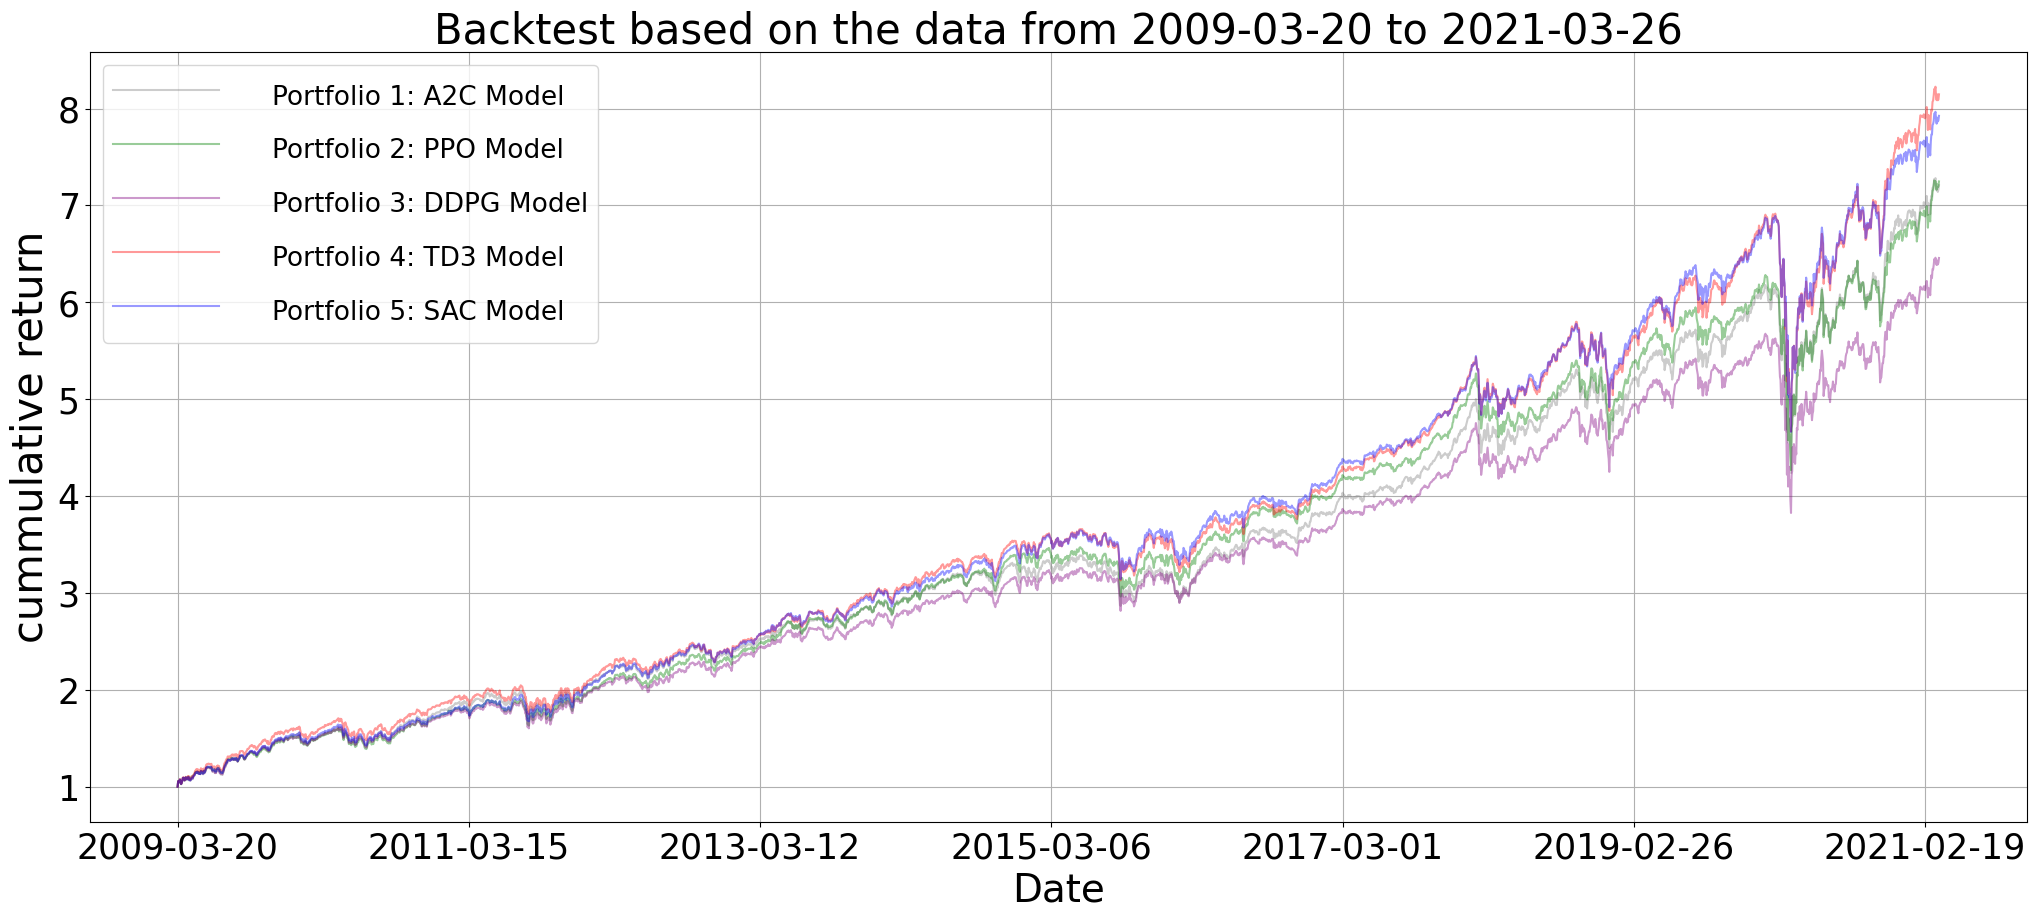

In [113]:
# Plot the culmulative returns of the portfolios
#fig, ax = plt.subplots(figsize=(8, 4))
fig, ax = plt.subplots(figsize=(25, 10))

#uw_cum_returns.plot(ax=ax, color="black", alpha=0.4)
#max_sharpe_cum_returns.plot(ax=ax, color="darkorange", alpha=0.4)

a2c_train_cum_returns.plot(ax=ax, color='gray', alpha=0.4)
ppo_train_cum_returns.plot(ax=ax, color='green', alpha=0.4)
ddpg_train_cum_returns.plot(ax=ax, color='purple', alpha=0.4)
td3_train_cum_returns.plot(ax=ax, color='red', alpha=0.4)
sac_train_cum_returns.plot(ax=ax, color='blue', alpha=0.4)
plt.legend(loc="best", fontsize=19, handlelength=4,
           handleheight=2, handletextpad=2)
plt.grid(True)
ax.set_ylabel("cummulative return", fontsize=30)
ax.set_xlabel("Date", fontsize=28)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)
ax.set_title(
    "Backtest based on the data from 2009-03-20 to 2021-03-26", fontsize=30)
fig.savefig('results/back_test_on_train_data.pdf')

### 6.4 Evaluating the Portfolios on Test Data

In [114]:
import pandas as pd

shahin_new_return_alghortihm_eachstock_return = pd.read_csv(
    'hosini_daily_return.csv')
shahin_new_return_alghortihm_eachstock_return['daily_return'] = shahin_new_return_alghortihm_eachstock_return.sum(axis=1)

In [115]:
shahin_new_return_alghortihm_eachstock_return['daily_return']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
750   -0.000319
751   -0.005171
752   -0.000791
753   -0.001920
754    0.012430
Name: daily_return, Length: 755, dtype: float64

In [116]:
returns_train

,MCD,CVX,DD,PG,UNH,V,WBA,RTX,INTC,VZ,...,AAPL,GS,IBM,TRV,HD,CAT,XOM,DIS,KO,BA
date,,,,,,,,,,,,,,,,,,,,,
2008-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-03-20,0.014163,0.016119,0.001923,0.023006,-0.006469,0.138938,0.010995,0.003636,0.031294,0.028181,...,0.027763,0.078923,0.011887,0.029735,0.045455,0.001221,0.006751,0.021127,0.018012,0.018380
2008-03-24,0.024807,0.009614,0.032346,0.008649,0.011042,-0.071795,0.049755,0.019273,0.017471,0.023533,...,0.046972,-0.004175,0.006169,-0.002092,0.042765,0.029938,0.011176,0.004389,0.002293,0.019920
2008-03-25,0.007710,0.006309,0.005311,-0.006146,-0.012042,0.058932,-0.015540,-0.002560,0.006326,-0.001894,...,0.010392,0.004192,-0.009155,0.001468,-0.017088,0.008023,-0.008726,0.001248,0.003760,-0.005112
2008-03-26,-0.010676,0.004967,-0.001321,0.001438,-0.033447,0.011225,-0.001315,-0.007839,-0.018410,-0.020596,...,0.028941,-0.023103,-0.008986,-0.004398,-0.020863,0.009394,0.012441,-0.009975,-0.004234,0.005270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22,0.011823,-0.008125,0.005966,0.016952,0.003501,0.005317,0.010849,-0.018377,0.029329,0.006223,...,0.028336,-0.014149,0.012800,-0.011454,-0.000553,0.003240,-0.010267,0.008999,0.003739,-0.017942
2021-03-23,-0.003110,-0.005559,-0.028881,0.018590,0.004471,0.000721,-0.020335,-0.022621,-0.032759,0.005655,...,-0.006889,-0.022279,-0.000689,-0.003997,0.003599,-0.034377,-0.012341,-0.021415,0.007647,-0.039725
2021-03-24,-0.001426,0.026773,0.018056,-0.000302,0.005699,-0.000384,-0.004805,0.004922,-0.022684,0.001757,...,-0.019993,-0.009404,0.001226,0.015510,0.009552,0.013654,0.020282,-0.021247,0.002530,-0.008332


In [117]:
# get the culmulative returns for each portfolio
uw_weights = uniform_weights_port.values.flatten()
uw_test_returns = returns_test.dot(uw_weights)
uw_test_cum_returns = (1 + uw_test_returns).cumprod()
uw_test_cum_returns.name = "portfolio: uniform weights"

max_sharpe_weights = max_sharpe_portfolio.values.flatten()
max_sharpe_test_returns = returns_test.dot(max_sharpe_weights)
max_sharpe_test_cum_returns = (1 + max_sharpe_test_returns).cumprod()
max_sharpe_test_cum_returns.name = "portfolio: max sharpe"

a2c_test_cum_returns = (1 + a2c_test_returns['daily_return']).cumprod()
a2c_test_cum_returns.name = 'Portfolio 1: A2C Model'

ppo_test_cum_returns = (1 + ppo_test_returns['daily_return']).cumprod()
ppo_test_cum_returns.name = 'Portfolio 2: PPO Model'

ddpg_test_cum_returns = (1 + ddpg_test_returns['daily_return']).cumprod()
ddpg_test_cum_returns.name = 'Portfolio 3: DDPG Model'

td3_test_cum_returns = (1 + td3_test_returns['daily_return']).cumprod()
td3_test_cum_returns.name = 'Portfolio 4: TD3 Model'

sac_test_cum_returns = (1 + sac_test_returns['daily_return']).cumprod()
sac_test_cum_returns.name = 'Portfolio 5: SAC Model'

all_agents_normalized_test_cum_return = (
    1 + all_agents_normalized_test_daily_return['daily_return']).cumprod()
all_agents_normalized_test_cum_return.name = 'Portfolio 6: Proposed method 1'

shahin_cum_new_return_alghortihm_eachstock_return = (
    1 + shahin_new_return_alghortihm_eachstock_return['daily_return']).cumprod()
shahin_cum_new_return_alghortihm_eachstock_return.name = 'Portfolio 7: Main proposed method'

a2c_test_cum_returns.to_csv('./confrenceresult/a2c_test_cum_returns.csv')
ppo_test_cum_returns.to_csv('./confrenceresult/ppo_test_cum_returns.csv')
ddpg_test_cum_returns.to_csv('./confrenceresult/ddpg_test_cum_returns.csv')
td3_test_cum_returns.to_csv('./confrenceresult/td3_test_cum_returns.csv')
sac_test_cum_returns.to_csv('./confrenceresult/sac_test_cum_returns.csv')
all_agents_normalized_test_cum_return.to_csv(
    './confrenceresult/all_agents_normalized_test_cum_return.csv')
shahin_cum_new_return_alghortihm_eachstock_return.to_csv(
    './confrenceresult/shahin_cum_new_return_alghortihm_eachstock_return.csv')

In [118]:
a2c_test_cum_returns

0      1.000000
1      0.993346
2      0.991031
3      0.996304
4      1.004438
         ...   
750    1.290830
751    1.284737
752    1.284731
753    1.283294
754    1.302035
Name: Portfolio 1: A2C Model, Length: 755, dtype: float64

In [119]:
shahin_cum_new_return_alghortihm_eachstock_return

0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
         ...   
750    1.370386
751    1.363300
752    1.362222
753    1.359606
754    1.376506
Name: Portfolio 7: Main proposed method, Length: 755, dtype: float64

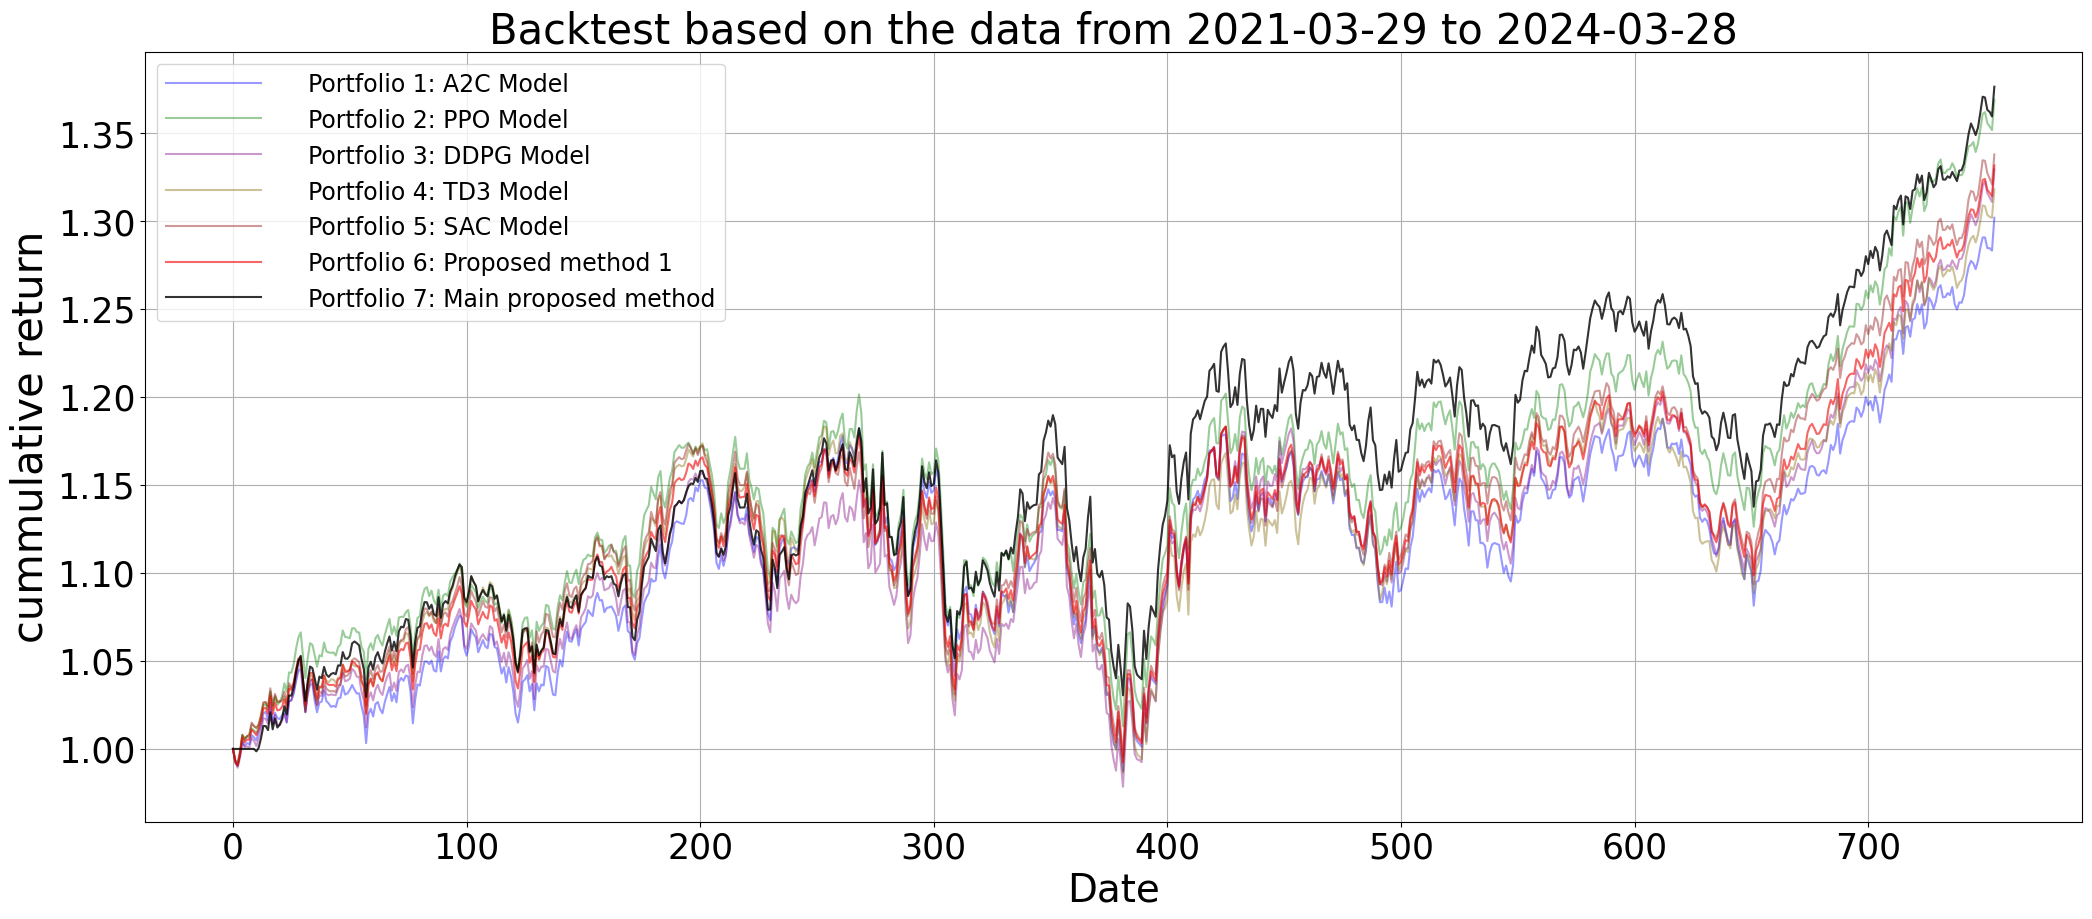

In [120]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(25,10))
#fig, ax = plt.subplots(figsize=(8, 4))
#uw_test_cum_returns.plot(ax=ax, color="black", alpha=.4);
#max_sharpe_test_cum_returns.plot(ax=ax, color="darkorange");
a2c_test_cum_returns.plot(ax=ax, color='blue', alpha=.4);
ppo_test_cum_returns.plot(ax=ax, color='green', alpha=.4);
ddpg_test_cum_returns.plot(ax=ax, color='purple', alpha=.4);
td3_test_cum_returns.plot(ax=ax, color=(0.5, 0.4, 0.0), alpha=0.4);
sac_test_cum_returns.plot(ax=ax, color='darkred', alpha=0.4);
#dr_kargar_second_cum_returns.plot(ax=ax, color='darkred', alpha=0.4)
all_agents_normalized_test_cum_return.plot(ax=ax, color=(0.95, 0.0, 0.0), alpha=0.6)
shahin_cum_new_return_alghortihm_eachstock_return.plot(ax=ax, color='black', alpha=0.8)
plt.legend(loc="best", fontsize=17, handlelength=4, handleheight=1,handletextpad=2);
plt.grid(True);
ax.set_ylabel("cummulative return", fontsize = 30);
ax.set_xlabel("Date", fontsize=28);
ax.set_title("Backtest based on the data from 2021-03-29 to 2024-03-28", fontsize=30);
ax.tick_params(axis='x', labelsize=25);
ax.tick_params(axis='y', labelsize=25);
fig.savefig('results/back_test_on_test_data.pdf');

### 6.5 Get the Portfolio Statistics

In [121]:
# Define a Function for Getting the Portfolio Statistics

def portfolio_stats(portfolio_returns):
    # Pass the returns into a dataframe
    port_rets_df = pd.DataFrame(portfolio_returns)
    port_rets_df = port_rets_df.reset_index()
    port_rets_df.columns = ['date', 'daily_return']

    # Use the FinRL Library to get the Portfolio Returns
    # This makes use of the Pyfolio Library

    DRL_strat = backtest_strat(port_rets_df)
    perf_func = timeseries.perf_stats
    perf_stats_all = perf_func(returns=DRL_strat,
                               factor_returns=DRL_strat,
                               positions=None, transactions=None, turnover_denom="AGB")
    perf_stats_all = pd.DataFrame(perf_stats_all)
    perf_stats_all.columns = ['Statistic']
    return perf_stats_all

In [122]:
shahin_new_return_alghortihm_eachstock_return

,AAPL,CAT,CSCO,CVX,DIS,HD,IBM,JNJ,KO,MCD,...,MRK,MSFT,PFE,PG,RTX,V,VZ,WMT,XOM,daily_return
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
2,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,-0.003291,0.001833,0.000197,0.000059,0.000166,0.000832,-0.000315,-0.000005,-0.000371,-0.000096,...,-0.000055,0.000784,-0.000116,-0.000024,-0.000501,0.000112,0.000310,0.000097,0.000131,-0.000319
751,0.000131,-0.001184,-0.000134,-0.000032,-0.000476,-0.000833,-0.000370,-0.000082,0.000022,-0.000212,...,0.000125,-0.000036,-0.000726,-0.000083,0.000334,-0.000603,-0.000103,-0.000232,0.000000,-0.005171
752,-0.000669,-0.000486,-0.000060,0.000347,0.002426,-0.000514,-0.000318,-0.000005,-0.000120,-0.000420,...,0.000349,-0.001105,0.000206,-0.000269,0.000076,-0.000214,0.000367,-0.000146,0.000303,-0.000791
753,-0.000164,0.000083,-0.000175,-0.000189,0.000320,-0.000625,-0.000103,0.000087,0.000155,0.000000,...,0.000112,-0.000070,0.000390,0.000150,0.000111,-0.000053,-0.000012,-0.000024,-0.000502,-0.001920


In [123]:
# Get the Portfolio Statistics for all the portfolios
portfolios_returns_dict = {'uniform_weights': uw_test_returns, 'maximum_sharpe': max_sharpe_test_returns,
                           'a2c Model': a2c_test_returns['daily_return'],
                           'ppo Model': ppo_test_returns['daily_return'],
                           'ddpg Model': ddpg_test_returns['daily_return'],
                           'td3 Model': td3_test_returns['daily_return'],
                           'sac Model': sac_test_returns['daily_return'],
                           'all_agents_normalized Model': all_agents_normalized_test_daily_return['daily_return'],
                           'second_alg': shahin_new_return_alghortihm_eachstock_return['daily_return']
                           }

portfolios_stats = pd.DataFrame()
for i, j in portfolios_returns_dict.items():
    port_stats = portfolio_stats(j)
    portfolios_stats[i] = port_stats['Statistic']

In [124]:
portfolios_stats.to_csv('portfolios_stats.csv')
portfolios_stats

,uniform_weights,maximum_sharpe,a2c Model,ppo Model,ddpg Model,td3 Model,sac Model,all_agents_normalized Model,second_alg
Annual return,0.083845,0.086481,0.092089,0.110548,0.099690,0.096580,0.102061,0.100335,0.112553
Cumulative returns,0.273214,0.282527,0.302035,0.369089,0.329375,0.318143,0.337979,0.331712,0.376506
Annual volatility,0.145696,0.160826,0.135402,0.133835,0.133785,0.138215,0.137146,0.134618,0.135106
Sharpe ratio,0.626237,0.596858,0.718344,0.850480,0.777285,0.736236,0.777259,0.777662,0.857102
Calmar ratio,0.416429,0.371496,0.558491,0.703933,0.645919,0.581306,0.674625,0.638486,0.840651
Stability,0.359670,0.249236,0.602492,0.653816,0.637802,0.531270,0.622671,0.619725,0.791564
Max drawdown,-0.201342,-0.232791,-0.164890,-0.157044,-0.154339,-0.166144,-0.151285,-0.157146,-0.133888
Omega ratio,1.112455,1.108330,1.129605,1.154260,1.139503,1.134327,1.142013,1.141078,1.157601
Sortino ratio,0.899536,0.859631,1.033818,1.227037,1.115114,1.057211,1.119061,1.117744,1.235617
Skew,NaN,NaN,-0.084312,-0.144316,-0.151374,-0.152979,-0.139564,-0.142507,-0.157155


### 6.6 Benchmarking the Best Portfolio against the Benchmark Index

In [125]:
#a2c_test_returns = a2c_test_returns.set_index('date')
ppo_test_returns = ppo_test_returns.set_index('date')
ddpg_test_returns = ddpg_test_returns.set_index('date')

In [126]:
a2c_test_returns.head()

,date,daily_return
0,2021-03-29,0.000000
1,2021-03-30,-0.006654
2,2021-03-31,-0.002331
3,2021-04-01,0.005321
4,2021-04-05,0.008164


In [127]:
# Getting the best performing portfolio

ps_cum = [a2c_test_cum_returns, ppo_test_cum_returns,
          ddpg_test_cum_returns, td3_test_cum_returns, sac_test_cum_returns, shahin_cum_new_return_alghortihm_eachstock_return]
ps = [a2c_test_returns['daily_return'], ppo_test_returns['daily_return'],
      ddpg_test_returns['daily_return'], td3_test_returns['daily_return'], sac_test_returns['daily_return'], shahin_new_return_alghortihm_eachstock_return['daily_return']]

final_return = []
for p in ps_cum:
    final_return.append(p.iloc[-1])

id_ = np.argmax(final_return)
best_p = ps[id_]
best_p.name = (ps_cum[id_]).name

print("Best portfolio: ",  best_p.name)
print("Final cumulative return: {:.2f} ".format(final_return[id_]))

Best portfolio:  Portfolio 7: Main proposed method
Final cumulative return: 1.38 


In [128]:
# convert the best portfolio into a Dataframe

best_p = pd.DataFrame(best_p)
best_p = best_p.reset_index()
best_p.columns=['date','daily_return']
best_p['date'] = a2c_test_returns['date']

In [129]:
best_p.head()

,date,daily_return
0,2021-03-29,0.0
1,2021-03-30,0.0
2,2021-03-31,0.0
3,2021-04-01,0.0
4,2021-04-05,0.0


In [130]:
# Best portfolio stats
best_port_strat = backtest_strat(best_p)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=best_port_strat, factor_returns=best_port_strat,  positions=None, transactions=None, turnover_denom="AGB")

In [131]:
from backtest import BaselineStats
prices_test_dates = list(prices_test_df.index)
print("==============Get Index Stats===========")

baesline_perf_stats=BaselineStats('^DJI', baseline_start = prices_test_dates[0], baseline_end = prices_test_dates[-1])

[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['^DJI']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


==============Get Index Stats===========


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
dji, dow_strat = baseline_strat('^DJI',prices_test_dates[1], prices_test_dates[-1])

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (754, 12)


In [ ]:
dow_strat

date
2021-03-30 00:00:00+00:00         NaN
2021-03-31 00:00:00+00:00   -0.002583
2021-04-01 00:00:00+00:00    0.005205
2021-04-05 00:00:00+00:00    0.011280
2021-04-06 00:00:00+00:00   -0.002892
                               ...   
2024-03-21 00:00:00+00:00    0.006814
2024-03-22 00:00:00+00:00   -0.007679
2024-03-25 00:00:00+00:00   -0.004110
2024-03-26 00:00:00+00:00   -0.000796
2024-03-27 00:00:00+00:00    0.012162
Length: 754, dtype: float64

In [ ]:
dow_strat_cum.name = 'Portfolio: dow_strat'

NameError: name 'dow_strat_cum' is not defined

In [ ]:
dow_strat_cum = (1 + dow_strat['daily_return']).cumprod()


KeyError: 'daily_return'

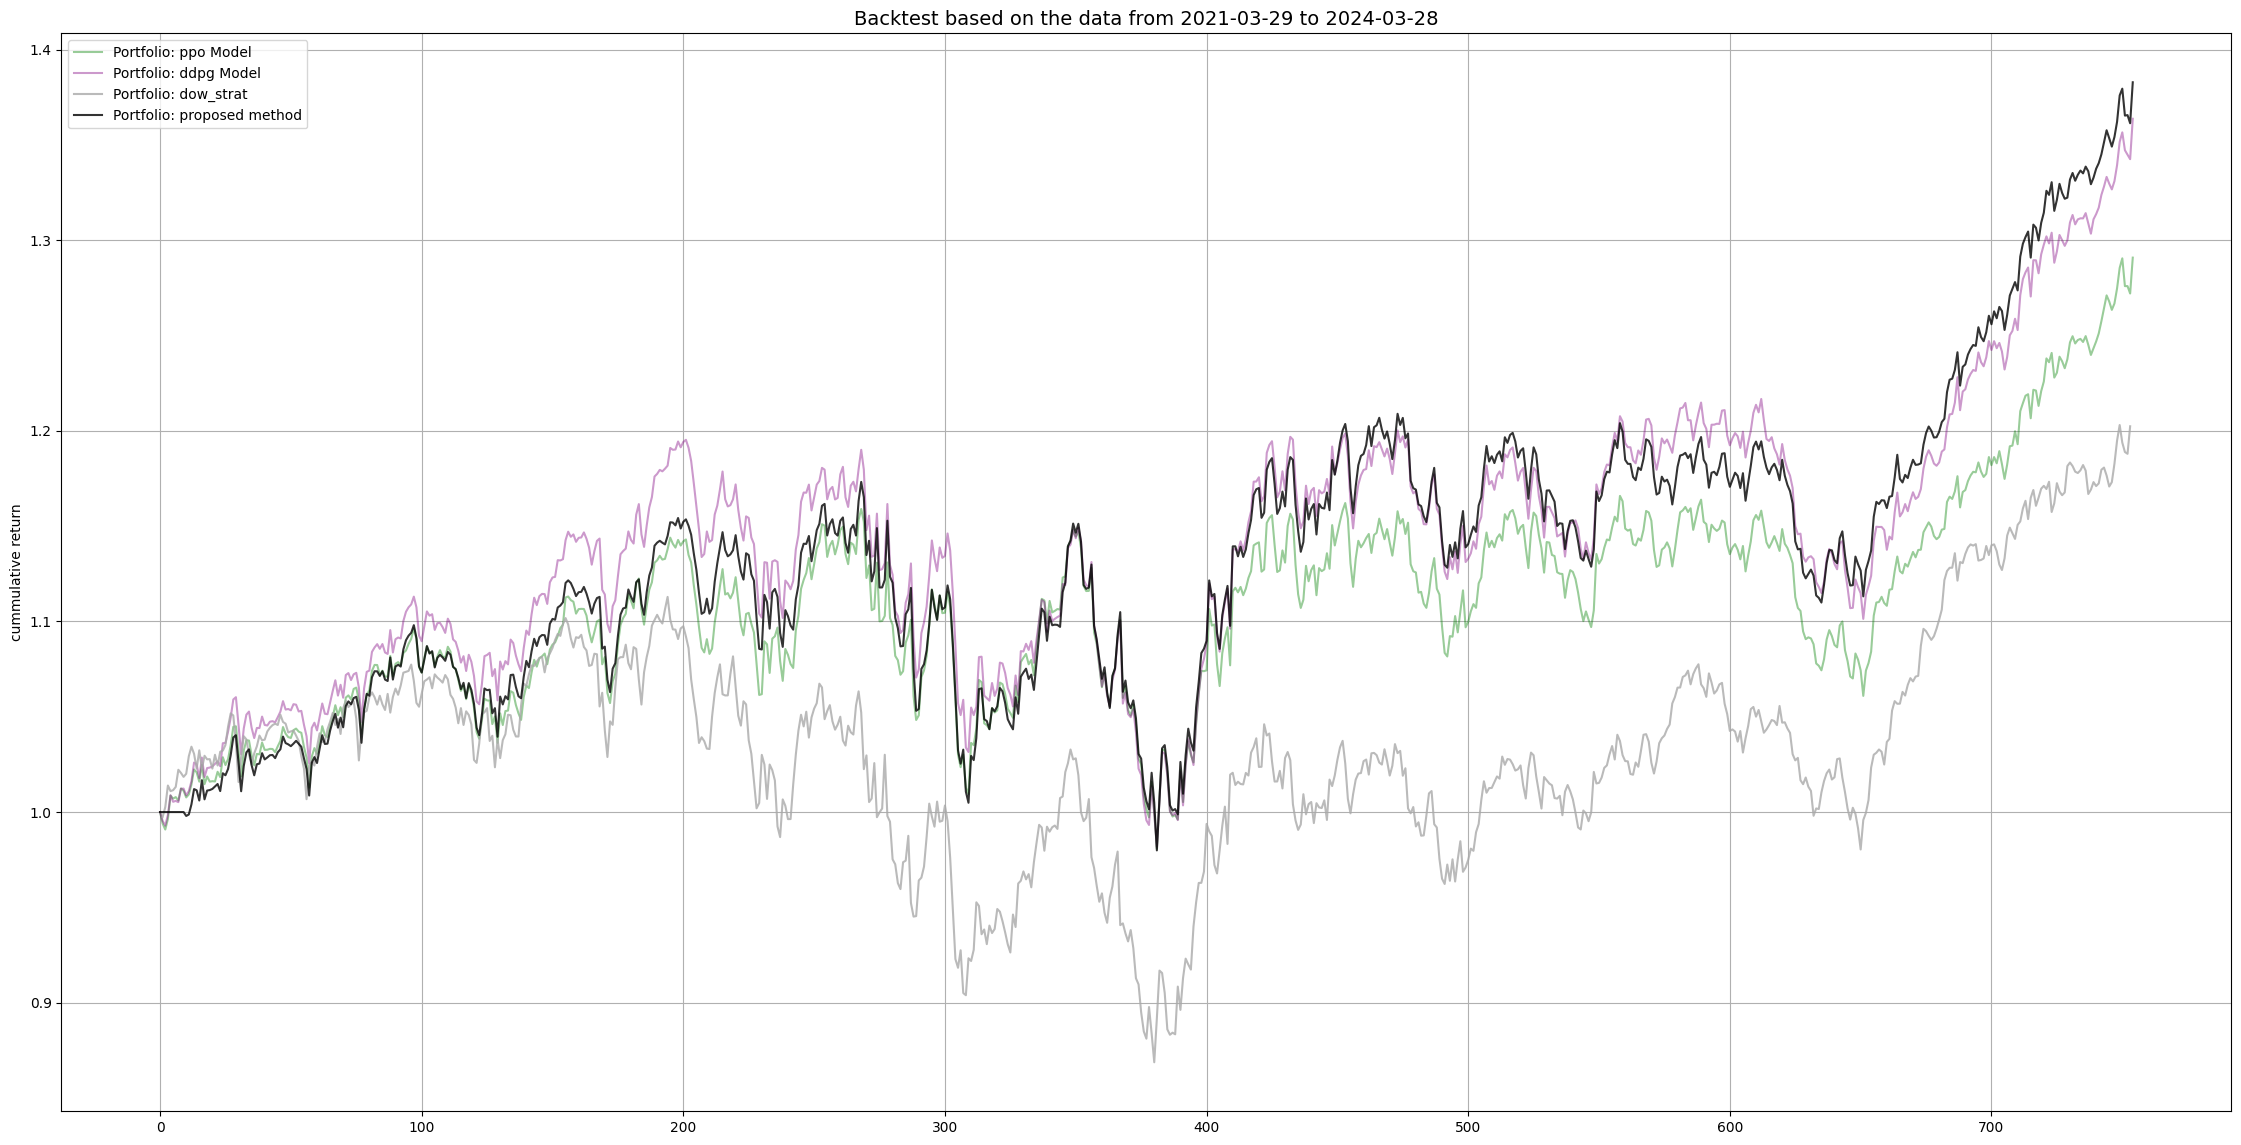

In [ ]:
# Plot the culmulative returns of the portfolios
fig, ax = plt.subplots(figsize=(28, 14))
# uw_test_cum_returns.plot(ax=ax, color="black", alpha=.4);
# max_sharpe_test_cum_returns.plot(ax=ax, color="darkorange");
#a2c_test_cum_returns.plot(ax=ax, color='blue', alpha=.4)
ppo_test_cum_returns.plot(ax=ax, color='green', alpha=.4)
ddpg_test_cum_returns.plot(ax=ax, color='purple', alpha=.4)
dow_strat_cum.plot(ax=ax, color='darkgray', alpha=0.8)
#sac_test_cum_returns.plot(ax=ax, color='darkred', alpha=0.4)
# dr_kargar_second_cum_returns.plot(ax=ax, color='darkred', alpha=0.4)
shahin_cum_new_return_alghortihm_eachstock_return.plot(
    ax=ax, color='black', alpha=0.8)
#all_agents_normalized_test_cum_return.plot(ax=ax, color='darkred', alpha=0.4)
plt.legend(loc="best")
plt.grid(True)
ax.set_ylabel("cummulative return")
ax.set_title(
    "Backtest based on the data from 2021-03-29 to 2024-03-28", fontsize=14)
fig.savefig('results/back_test_on_test_data.pdf')